<a href="https://colab.research.google.com/github/AlexandraGl/LaserHeatingSamp/blob/master/Tav_Tmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Description

Calculating surface temperature parameters (maximum temperature, average temperature) for laser heated carbon samples.

In [0]:
from PIL import Image, ImageStat
import math
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from datetime import datetime

mounting google drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


#Calibrating image (rgb) of the lamp according to the current value

##Defining constants and functions

In [0]:
rgb = {'r': 0, 'g': 1, 'b': 2} #dictionary of bands
i_l = 19.02 #lamp current from cam_calibration setup

Enetering band and threshold value

In [0]:
val = 200
band = 'r'

Define function of the mask. Return image area, where given band (r,g,b) exceeds given value.

In [0]:
def get_mask(image, value, band):
    # make copy of image to retain the original one
    im2 = image.copy()
    source = im2.split()
    # select regions where band is more than given value
    return source[rgb[band]].point(lambda i: i > value and 255)

Define function for calculation of brightness temperature for lamp current:

-123.131*x +1457.390*x^0.5 - 1945.930

In [0]:
def cfunc(i_lamp):
  return -123.131*i_lamp + 1457.390*i_lamp**0.5 - 1945.930

Function return mean value of RGB intensities for picture area, where "band" intensity exceeds "val"

In [0]:
def av_rgb_area(im, band, val):
  mask = get_mask(im, val, band)
  stat = ImageStat.Stat(im, mask)
  return stat.mean

##Calculating brightness temperature for lamp from current

In [0]:
t_b = cfunc(i_l)
print(f"Lamp brightness temperature {t_b}")

Lamp brightness temperature 2068.0767138897054


Open image of lamp for calibration

In [0]:
impath = '/gdrive/My Drive/HyperLab/Lheating/cam_calibration/011/ImgA000099.tif' 
im = Image.open(impath,'r')


Calculating average intensities for rgb bands of selected region of picture

In [0]:
av_rgb = av_rgb_area(im, band, val)

Defining 2 bands from RGB

In [0]:
band1 = 'r'
band2 = 'g'

Calculating average ratio of selected bands' intesities.

In [0]:
av_r = av_rgb[rgb[band1]]/av_rgb[rgb[band2]]
#print(av_ratio)

#Calculating temperature parameters of heated samples

##Defining constants and functions

Defining wave length $\lambda$ for RGB bands. According to the Motion ProX spectral responce

In [0]:
lambda_rgb = {'r': 630e-9, 'g': 530e-9, 'b': 500e-9}

Defining spectral emissivity factor $\epsilon_\lambda$  for RGB wave lengths fo wolfram at temperature of 2000K

---



In [0]:
eps_rgb = {'r': 0.438, 'g': 0.454, 'b': 0.459}

Defining constant C = hc/k

In [0]:
C = 1.44e-2
print(f"hc/k = {C}")

hc/k = 0.0144


Initializing function for calculating absolute temperature of lamp $\cfrac{1}{T} = \cfrac{1}{T_b}+\cfrac{\lambda}{C}ln\epsilon_\lambda$


In [0]:
def temp_abs(lambd, eps, t_b):
  return 1/(1/t_b + (lambd/C)*math.log(eps))

Initializing function for calculating sample temperature:

$B_r - Const*exp(\cfrac{A}{T_s}) = 0$
 
 where $B_r = \cfrac{B_s(\lambda_1, T_s)}{B_s(\lambda_2, T_s)} \cfrac{B_l(\lambda_2, T_l)}{B_l(\lambda_1, T_l)}$,
 $Const = \cfrac{\epsilon_l(\lambda_2,T_l)}{\epsilon_l(\lambda_1,T_l)}*exp(-\cfrac{A}{T_l})$, 
 $A = \cfrac{hc}{k}(\cfrac{1}{\lambda_2} - \cfrac{1}{\lambda_1})$


Defining constants A, Const

In [0]:
A = C*(1/lambda_rgb[band2] - 1/lambda_rgb[band1])
Eps_r = eps_rgb[band1]/eps_rgb[band2]
t_l = temp_abs(lambda_rgb[band1], eps_rgb[band1], t_b)
Const = 1/(math.exp(A/t_l)*Eps_r)
#print(A)

4312.668463611861


In [0]:
def temp_f(t_s):
  return Br_r - Const*math.exp(A/t_s)

Open image of experiment with sample and specify the noise signal



In [0]:
impath_c = "/gdrive/My Drive/HyperLab/Lheating/2018.07.10.laser/019/Acq_A/ImgA" #path constant
val_n = 4 #noise value
Tmax_f = np.zeros(3271)
Tav_f = np.zeros(3271))

##Calculating temperature

Calculating temperature for each point in the area where R, G, B channel values exceed noise value.

For each picture calculating maximum and average temperature, store in arrays Tmax_f and Tav_f

In [0]:
start = datetime.now()
for i in range(3271):
    tmp = str(i)
    impath = impath_c + tmp.zfill(6) + ".tif"
    samp_im = Image.open(impath,'r')
    np_im = np.array(samp_im) #Convert to numpy, calc mask for noise signal
    r,g,b = np_im[25:,:,0], np_im[25:,:,1], np_im[25:,:,2]
    mask_r = r > val_n
    mask_g = g > val_n
    mask_b = b > val_n
    mask_rgb = mask_r*mask_g*mask_b #mask where all r g and b bands exceed noise value
    if r[mask_rgb].size > 0:
        br_r = r[mask_rgb]/g[mask_rgb]#calc brightness ratio of r and g bands
        T_abs = np.zeros(br_r.size)
        for k in range(br_r.size):
            Br_r = br_r[k]/av_r
            sol = optimize.root_scalar(temp_f, bracket=[10, 10000], method='brentq')
            T_abs[k] = sol.root
        Tmax_f[i] = np.amax(T_abs)
        Tav_f[i] = np.average(T_abs)
    else:
        i = i+1

dt = datetime.now() - start  


Check whether all images was processed. Print number of image i.

In [0]:
print(i)

3271


Print maximum of Tmax_f and Tav_f arrays. Chek whether data is adequite. Print time of operation.

In [0]:
print(np.amax(Tmax_f), np.amax(Tav_f))
print(f'time operation: {dt}')

2866.330680689075 2565.818660599126
time operation: 0:24:08.207221


11:

max Tmax 3596.2461458028038,  max Tav 2380.1069003813404

10:

max Tmax 5433.2911873283265 ,  max Tav 2282.1456528721637

09:

max Tmax 2687.5583021741722,  max Tav 2418.8743230518576

In [0]:
time = np.zeros(3271)
for i in range(3271):
  time[i] = i/150


##Saving data

In [0]:
Tmax_t = np.column_stack((time,Tmax_f))
Tav_t = np.column_stack((time,Tav_f))

In [0]:
np.savetxt("/gdrive/My Drive/HyperLab/Lheating/2018.07.10.laser/019/Tmax_t.txt", Tmax_t, fmt='%4.12f', delimiter='\t', newline='\n', header='time, s'+'\t'+'max temperature, K', comments='# ')

In [0]:
np.savetxt("/gdrive/My Drive/HyperLab/Lheating/2018.07.10.laser/019/Tav_t.txt", Tav_t, fmt='%4.12f', delimiter='\t', newline='\n', header='time, s'+'\t'+'av temperature, K', comments='# ')

##Plotting results

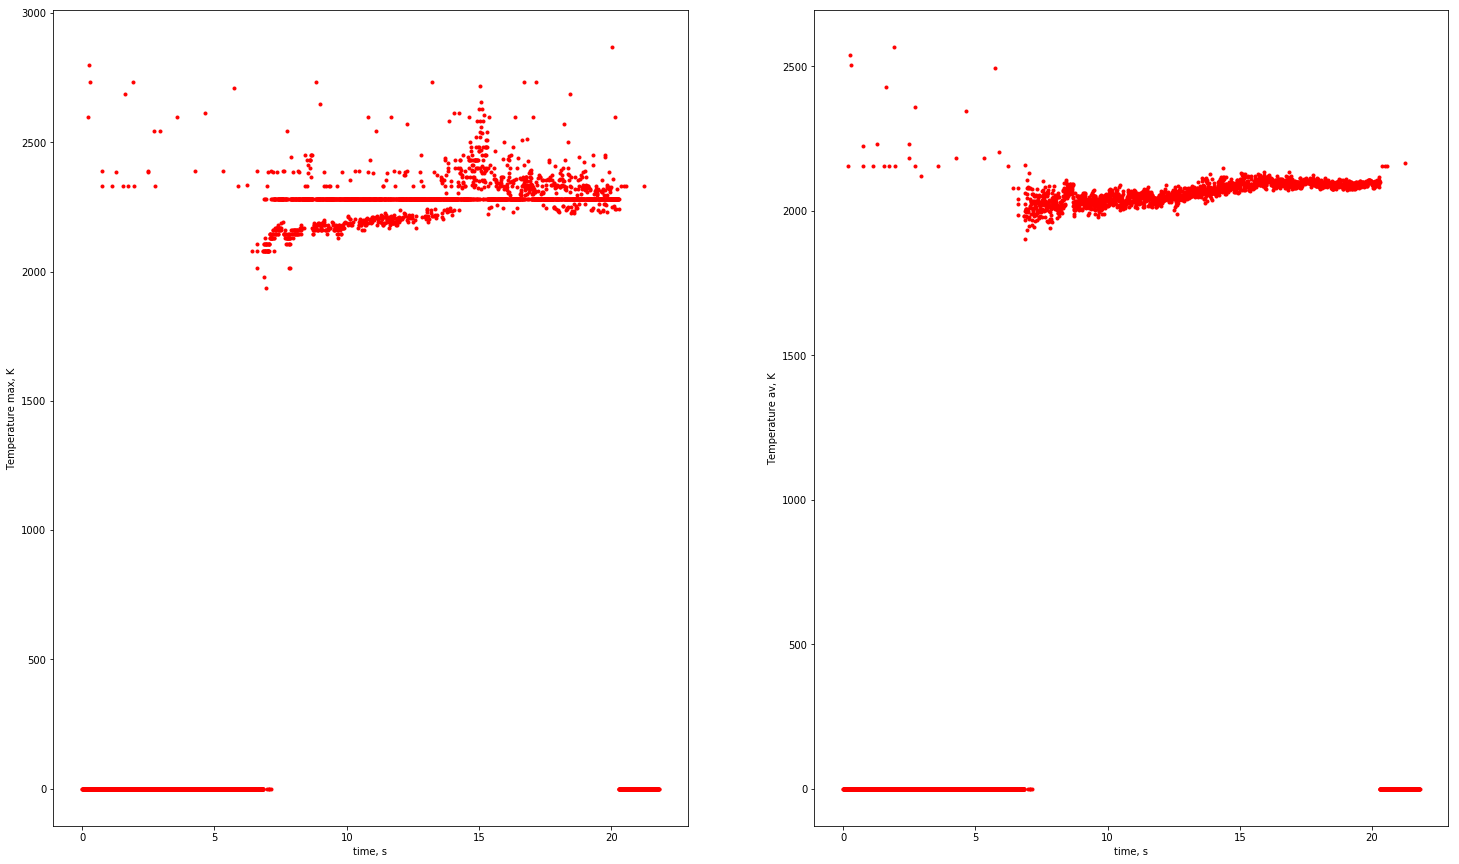

In [0]:
fig = plt.figure(figsize = (25,15))
fig.add_subplot(1, 2, 1)
plt.plot(time, Tmax_f, 'r.')
plt.xlabel('time, s')
plt.ylabel('Temperature max, K')
fig.add_subplot(1, 2, 2)
plt.plot(time, Tav_f, 'r.')
plt.xlabel('time, s')
plt.ylabel('Temperature av, K')
plt.show()